# iLINCS DiSignAtlas Overlap

## Overalp of DiSignAtlas with iLINCS

2024-01-29 12:51:29,824 - INFO - Retrieved a total of 1049/1084 GDS to GSE mappings
2024-01-29 12:51:53,871 - INFO - Retrieved a total of 1087 iLINCS datasets


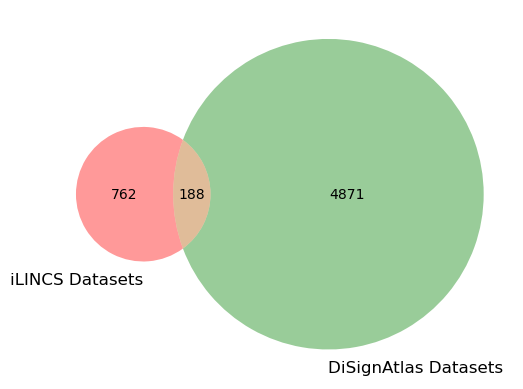

In [22]:
"""Overlap of DiSignAtlas w/ iLINCS

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Determine Overlap
    4. Plot Overlap
"""
# 1. Imports, Variables, Functions
# imports
import sys, os, pickle, logging, pandas as pd, numpy as np, requests
from tqdm import tqdm
import multiprocessing
from tqdm.contrib.concurrent import process_map
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
# variables
output_path_gds = os.path.join("..", "results", "files", "DiSignAtlas", "gds_2_gse.pkl")
iLINCS_filter = lambda s: (s["libraryid"] == "LIB_1")
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)

# functions


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    base_url = "http://www.ilincs.org/api"
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)
    base_url = "http://www.ilincs.org/api"
    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def process_dataset(dataset_id):
    # retrieve metadata from iLINCS for specific datasetid
    metadata = fetch_dataset_metadata(dataset_id)
    gds_id = metadata["SourceID"]
    return gds_id


# 2. Load Data
# load iLINCS GDS -> GSE mapping
# this was previously mapped using Entrez API ! ! ! (DiSignAtlas.ipynb)
with open(output_path_gds, "rb") as f:
    iLINCS_gds_2_gse = pickle.load(f)

logging.info(
    f"Retrieved a total of {len([k for k, v in iLINCS_gds_2_gse.items() if v.startswith('GSE')])}/{len(iLINCS_gds_2_gse)} GDS to GSE mappings"
)

# get iLINCS GSE ids
iLINCS_gse_ids = list(
    set([v for v in iLINCS_gds_2_gse.values() if v.startswith("GSE")])
)

# load iLINCS datasets
signatures = fetch_disease_signatures()
iLINCS_datasets = list(set([s["datasetid"] for s in signatures if iLINCS_filter(s)]))

logging.info(f"Retrieved a total of {len(iLINCS_datasets)} iLINCS datasets")


# load DiSignAtlas datasets
df_DS_data_info = pd.read_csv(data_info_path)
DS_gse_ids = df_DS_data_info["accession"].tolist()

# 3. Determine Overlap
# get gse ids for iLINCS datasets
common_gse_ids = list(set(iLINCS_gse_ids).intersection(set(DS_gse_ids)))

# 4. Plot Overlap
# Create the Venn diagram
venn2(
    [set(iLINCS_gse_ids), set(DS_gse_ids)],
    set_labels=("iLINCS Datasets", "DiSignAtlas Datasets"),
)

## Get Signatures for common datasets

In [36]:
"""Structure:
    1. Imports, Variables, Functions
    2. Map datasets to signatures
    3. Process iLINCS signatures
    4. Compute correlation between iLINCS and DiSignAtlas
"""

# 1. Imports, Variables, Functions
# imports

# variables
path_iLINCS_signature_info = os.path.join("..", "data", "iLINCS", "signatures.csv")
path_iLINCS_signatures = os.path.join(
    "..", "data", "iLINCS", "disease_signature_vectors"
)

# functions


def get_iLINCS_signature_id(dataset_id, df_iLINCS_signature_info):
    """Load iLINCS Signatures and return all signature IDs for a given dataset ID.
    Arguments:
        - dataset_id(str): Dataset ID
    Returns:
        - list: List of signature IDs
    """

    # Filter for signatures where libraryid is 'LIB_1'
    df_iLINCS_disease_signatures = df_iLINCS_signature_info[
        df_iLINCS_signature_info["libraryid"] == "LIB_1"
    ]

    # Remove 'gds' prefix from dataset IDs and find matching signature IDs
    df_iLINCS_disease_signatures.loc[:, "datasetid"] = df_iLINCS_disease_signatures[
        "datasetid"
    ].apply(lambda x: x.replace("gds", ""))

    # Filter the DataFrame for rows with the given dataset ID
    filtered_df = df_iLINCS_disease_signatures[
        df_iLINCS_disease_signatures["datasetid"] == dataset_id
    ]

    # Return a list of signature IDs
    return (
        filtered_df["signatureid"].tolist(),
        filtered_df["level1"].tolist(),
        filtered_df["level2"].tolist(),
    )


def filter_ilincs_signature(l1, l2, key_words):
    if (l1 is not np.nan) and (any([k in l1.lower() for k in key_words])):
        return True
    elif (l2 is not np.nan) and (any([k in l2.lower() for k in key_words])):
        return True
    else:
        return False


iLINCS_signatures_all = list()
iLINCS_l1s_all = list()
iLINCS_l2s_all = list()

DS_signatures_all = list()
DS_diseases_all = list()

# df iLINCS signatures
df_iLINCS_signature_info = pd.read_csv(path_iLINCS_signature_info, low_memory=False)

# iLINCS gse to gds
iLINCS_gse_2_gds = {v: k for k, v in iLINCS_gds_2_gse.items()}

# 2. Map datasets to signatures
# iterate through common gse ids
for gse_id in tqdm(common_gse_ids):
    # gds id
    gds_id = iLINCS_gse_2_gds[gse_id]

    # iLINCS signatures
    iLINCS_signature_ids, iLINCS_l1s, iLINCS_l2s = get_iLINCS_signature_id(
        gds_id, df_iLINCS_signature_info
    )
    iLINCS_signatures_all.append(iLINCS_signature_ids)
    iLINCS_l1s_all.append(iLINCS_l1s)
    iLINCS_l2s_all.append(iLINCS_l2s)

    # DiSignAtlas signatures
    DS_signatures = df_DS_data_info[df_DS_data_info["accession"] == gse_id][
        "dsaid"
    ].to_list()
    DS_diseases = df_DS_data_info[df_DS_data_info["accession"] == gse_id][
        "disease"
    ].to_list()
    DS_signatures_all.append(DS_signatures)
    DS_diseases_all.append(DS_diseases)

# 3. Process iLINCS signatures
# we are interested in signatures that correspond to control/normal/healthy
# differential expresions

# How many iLINCS signatures have control/normal/healthy conditions?
key_words = ["control", "normal", "healthy"]

# filtered iLINCS signatures
iLINCS_signatures_all_filtered = list()
iLINCS_l1s_all_filtered = list()
iLINCS_l2s_all_filtered = list()

for sublist_i, sublist_l1, sublist_l2 in zip(
    iLINCS_signatures_all, iLINCS_l1s_all, iLINCS_l2s_all
):
    i_found = list()
    l1_found = list()
    l2_found = list()
    for i, l1, l2 in zip(sublist_i, sublist_l1, sublist_l2):
        if filter_ilincs_signature(l1, l2, key_words):
            i_found.append(i)
            l1_found.append(l1)
            l2_found.append(l2)
    iLINCS_signatures_all_filtered.append(i_found)
    iLINCS_l1s_all_filtered.append(l1_found)
    iLINCS_l2s_all_filtered.append(l2_found)

# 4. Compute correlation between iLINCS and DiSignAtlas
# load large iLINCS dataframe
df_iLINCS_signatures = pd.read_csv(path_iLINCS_signatures)

# iterate through common gse ids
for index, gse_id in tqdm(common_gse_ids):
    # get gds id
    gds_id = iLINCS_gse_2_gds[gse_id]

    # get iLINCS signature ids
    iLINCS_signature_ids = iLINCS_signatures_all_filtered[index]
    if len(iLINCS_signature_ids) == 0:
        continue

    # store in each iteration signatures for each dataset
    iLINCS_gene_ids = list()
    iLINCS_gene_des = list()
    iLINCS_gene_pvalue = list()
    for iLINCS_signature_id in iLINCS_signature_ids:
        # get iLINCS signatures
        iLINCS_gene_id = df_iLINCS_signatures[
            df_iLINCS_signatures["signatureID"] == iLINCS_signature_id
        ]["ID_geneid"].to_list()
        iLINCS_gene_de = df_iLINCS_signatures[
            df_iLINCS_signatures["signatureID"] == iLINCS_signature_id
        ]["Value_LogDiffExp"].to_list()
        iLINCS_gene_pvalue = df_iLINCS_signatures[
            df_iLINCS_signatures["signatureID"] == iLINCS_signature_id
        ]["Significance_pvalue"].to_list()

        iLINCS_gene_ids.append(iLINCS_gene_id)
        iLINCS_gene_des.append(iLINCS_gene_des)
        iLINCS_gene_pvalue.append(iLINCS_gene_pvalue)

    # get DiSignAtlas signatures
    DS_signatures = DS_signatures_all[index]

    # store in each iteration signatures for each dataset
    DS_g


# get iLINCS pvalues for iLINCS signatures

# get iLINCS log2FC

100%|██████████| 188/188 [00:01<00:00, 98.57it/s] 


In [88]:
df_a = pd.read_csv(
    "/aloy/home/ddalton/projects/disease_signatures/data/iLINCS/disease_signature_vectors.csv"
)

In [89]:
df_a[].shape

(144545011, 6)

In [91]:
df_a[df_a["signatureID"] == "GDS_6172"].shape

(8478, 6)

In [92]:
df_a.columns

Index(['signatureID', 'PROBE', 'ID_geneid', 'Name_GeneSymbol',
       'Value_LogDiffExp', 'Significance_pvalue'],
      dtype='object')

In [ ]:
# get signatures for each common gse_id